In [2]:
import tensorboard as tb
import pandas as pd
import os
import numpy as np
from tensorflow.python.summary.summary_iterator import summary_iterator

2021-12-14 15:54:10.721783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 15:54:10.721801: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)

In [4]:
all_data = []
for iteration in range(5) :
    experiment_data = convert_tb_data(f'lightning_logs/scaffold_split_{iteration}/')
    experiment_data['Experiment'] = 'scaffold_split'
    experiment_data['Iteration'] = iteration
    
    all_data.append(experiment_data)
    
    experiment_data = convert_tb_data(f'lightning_logs/random_split_{iteration}/')
    experiment_data['Experiment'] = 'random_split'
    experiment_data['Iteration'] = iteration
    
    all_data.append(experiment_data)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [5]:
all_data = pd.concat(all_data)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

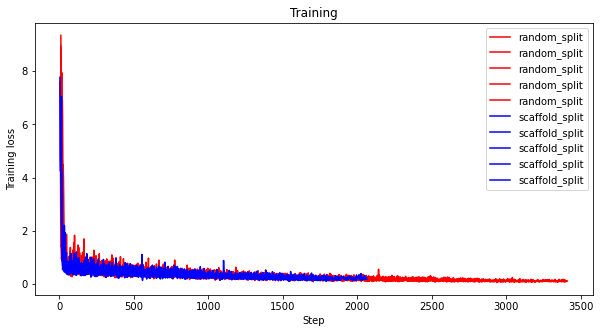

In [7]:
plt.figure(figsize=(10, 5))
for experiment in ['random_split', 'scaffold_split'] :
    for iteration in range(5) :
        subset = all_data[
            (all_data['Experiment'] == experiment)
            & (all_data['Iteration'] == iteration)
        ]
        subset_train_loss = subset [
            subset['name'] == 'train_loss'
        ]
        if experiment == 'random_split' :
            c = 'red'
        else :
            c = 'blue'
        plt.plot(subset_train_loss['value'], c=c, label=experiment)
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('Training loss')
plt.legend()
plt.show()

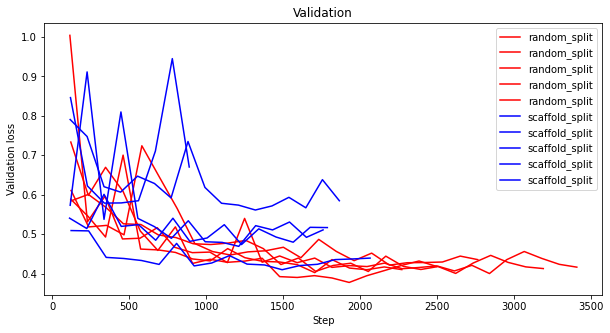

In [8]:
plt.figure(figsize=(10, 5))
for experiment in ['random_split', 'scaffold_split'] :
    for iteration in range(5) :
        subset = all_data[
            (all_data['Experiment'] == experiment)
            & (all_data['Iteration'] == iteration)
        ]
        subset_train_loss = subset [
            subset['name'] == 'val_loss'
        ]
        if experiment == 'random_split' :
            c = 'red'
        else :
            c = 'blue'
        plt.plot(subset_train_loss['value'], c=c, label=experiment)
plt.title('Validation')
plt.xlabel('Step')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

In [24]:
d_perf = {
    'scaffold_test' : {
        'mean_loss' : [0.42, 0.52, 0.45, 0.61, 0.50],
        'R2' : [0.46, 0.41, 0.42, 0.32, 0.45],
        'bio_top_accuracy' : [0.775, 0.761, 0.749, 0.680, 0.780],
        'median_bio_rank' : [0, 0, 0, 0, 0],
        'generated_rank0_accuracy' : [0.132, 0.127, 0.104, 0.088, 0.116],
        'ccdc_rank0_accuracy' : [0.156, 0.123, 0.115, 0.076, 0.127],
        'ef20%pred' : [1.58, 1.44, 1.39, 1.47],
        'ef20%ccdc' : [1.20, 1.26, 1.21, 1.14]
    },
    
    'scaffold_platinum' : {
        'mean_loss' : [0.80, 0.68, 0.83, 0.68, 0.85],
        'R2' : [-0.36, -0.14, -0.41, -0.15, -0.43],
        'bio_top_accuracy' : [0.258, 0.261, 0.265, 0.224, 0.252],
        'median_bio_rank' : [5, 4, 4, 7, 5],
        'generated_rank0_accuracy' : [0.114, 0.112, 0.114, 0.105, 0.113],
        'ccdc_rank0_accuracy' : [0.140, 0.140, 0.140, 0.140, 0.140],
        'ef20%pred' : [1.51, 1.48, 1.33, 1.49],
        'ef20%ccdc' : [1.37, 1.37, 1.37, 1.37]
    },
    
    'random_test' : {
        'mean_loss' : [0.22, 0.37, 0.26, 0.30, 0.30],
        'R2' : [0.61, 0.48, 0.59, 0.49, 0.54],
        'bio_top_accuracy' : [0.874, 0.866, 0.875, 0.874, 0.844],
        'median_bio_rank' : [0, 0, 0, 0, 0],
        'generated_rank0_accuracy' : [0.166, 0.152, 0.174, 0.113, 0.159],
        'ccdc_rank0_accuracy' : [0.137, 0.146, 0.143, 0.142, 0.164],
        'ef20%pred' : [2.13, 1.84, 1.93, 1.75, 1.86],
        'ef20%ccdc' : [1.35, 1.28, 1.26, 1.30, 1.30]
    },
    
    'random_platinum' : {
        'mean_loss' : [1.13, 0.77, 0.98, 0.93, 0.82],
        'R2' : [-0.95, -0.29, -0.67, -0.58, -0.39],
        'bio_top_accuracy' : [0.272, 0.270, 0.270, 0.276, 0.265],
        'median_bio_rank' : [4, 5, 4, 4, 5],
        'generated_rank0_accuracy' : [0.121, 0.115, 0.129, 0.109, 0.122],
        'ccdc_rank0_accuracy' : [0.140, 0.140, 0.140, 0.140, 0.140],
        'ef20%pred' : [1.63, 1.56, 1.61, 1.55, 1.57],
        'ef20%ccdc' : [1.37, 1.37, 1.37, 1.37, 1.37]
    }
}

In [25]:
l_perfs = []
for experiment in d_perf :
    for metric in d_perf[experiment] :
        for v in d_perf[experiment][metric] :
            l_perfs.append([experiment, metric, v])

In [26]:
df_perfs = pd.DataFrame(l_perfs, columns=['experiment', 'metric', 'value'])

In [27]:
df_perfs.head()

,experiment,metric,value
0,scaffold_test,mean_loss,0.42
1,scaffold_test,mean_loss,0.52
2,scaffold_test,mean_loss,0.45
3,scaffold_test,mean_loss,0.61
4,scaffold_test,mean_loss,0.50


In [28]:
df_perfs.pivot_table(index='experiment', values='value', columns='metric')

metric,R2,bio_top_accuracy,ccdc_rank0_accuracy,ef20%ccdc,ef20%pred,generated_rank0_accuracy,mean_loss,median_bio_rank
experiment,,,,,,,,
random_platinum,-0.576,0.2706,0.1400,1.3700,1.5840,0.1192,0.926,4.4
random_test,0.542,0.8666,0.1464,1.2980,1.9020,0.1528,0.290,0.0
scaffold_platinum,-0.298,0.2520,0.1400,1.3700,1.4525,0.1116,0.768,5.0
scaffold_test,0.412,0.7490,0.1194,1.2025,1.4700,0.1134,0.500,0.0


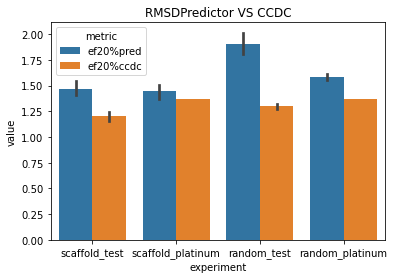

In [29]:
df_metric = df_perfs[df_perfs['metric'].isin(['ef20%ccdc', 'ef20%pred'])]
sns.barplot(data=df_metric, x='experiment', y='value', hue='metric')
plt.title('RMSDPredictor VS CCDC')
plt.show()

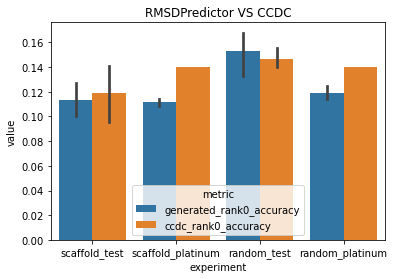

In [21]:
df_metric = df_perfs[df_perfs['metric'].isin(['ccdc_rank0_accuracy', 'generated_rank0_accuracy'])]
sns.barplot(data=df_metric, x='experiment', y='value', hue='metric')
plt.title('RMSDPredictor VS CCDC')
plt.show()

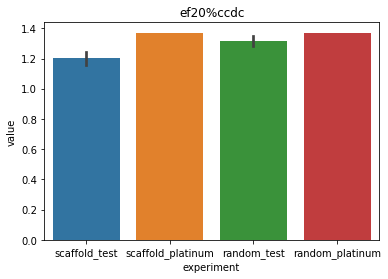

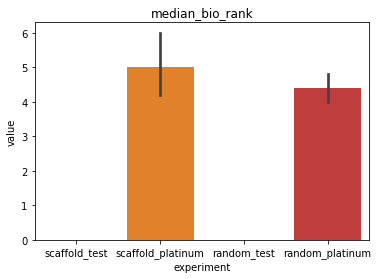

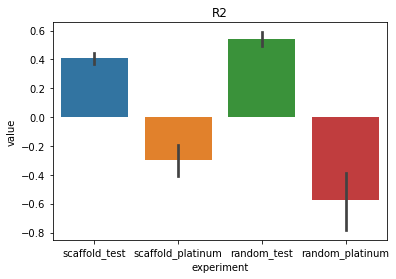

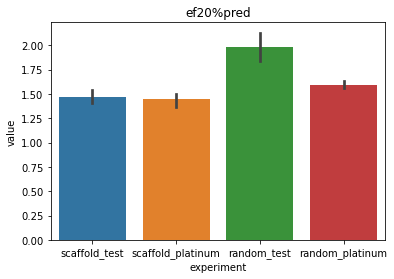

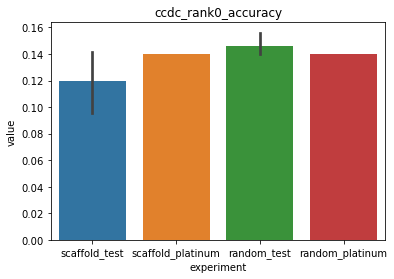

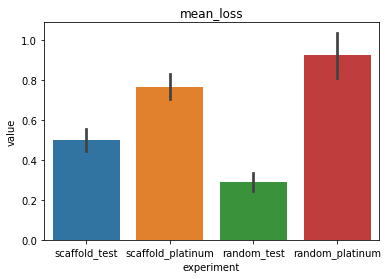

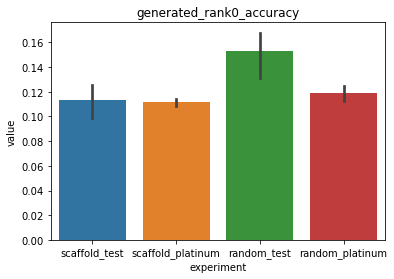

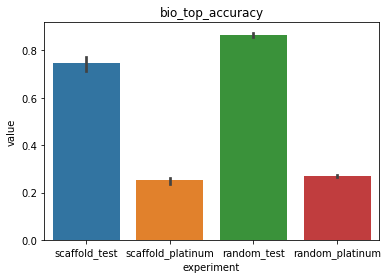

In [22]:
for metric in set(df_perfs['metric'].values) :
    df_metric = df_perfs[df_perfs['metric'] == metric]
    sns.barplot(data=df_metric, x='experiment', y='value')
    plt.title(metric)
    plt.show()

In [ ]:
sns.barplot(data=df_perfs, x='')

In [22]:
d_perf[experiment][metric]

[0, 0, 0, 0]

In [12]:
df = pd.DataFrame(d_perf)

In [16]:
mean_d_perf = {}
for metric in df.index :
    mean_d_perf[metric] = {}
    for experiment in df.columns :
        mean_d_perf[metric][experiment] = np.mean(df.loc[metric, experiment])

In [19]:
mean_df = pd.DataFrame(mean_d_perf)

In [ ]:
mean_df